# 8. 컨볼루션을 활용한 일반화
## 8.1 컨볼루션
### 8.1.1 컨볼루션의 역할
- 평행이동 불변성 : 지역화된 패턴이 이미지의 어떤 위치에 있더라도 동일하게 출력에 영향을 주는 성질
- 컨볼루션(이산 컨볼루션, discrete convolution) : 2차원 이미지에 가중치 행렬을 스칼라곱을 수행하는 것, 여기서 가중치 행렬은 커널(kernel)이라 함  

<img src="https://user-images.githubusercontent.com/107118671/189571492-0536a7d4-7b1a-45be-a385-4c999059f78b.png" width="70%" height="70%" align="left">

## 8.2 컨볼루션 사용해보기
- nn.Conv1d는 시계열용 nn.Conv2d는 이미지용 nn.Con3d는 용적 데이터나 동영상용
- CIFAR-10 데이터에 대해서는 nn.Conv2d 사용, 전달 인자는 최소 입력 피처수, 출력 피처 수, 커널의 크기

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [7]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [8]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

### 8.2.1 경계 패딩하기

In [9]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

### 8.2.2 컨볼루션으로 피처 찾아내기
- 가중치를 직접 설정해서 컨볼루션에서 어떤 일이 일어나는 지 알아보기

In [10]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

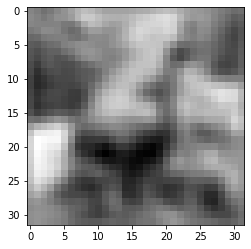

In [11]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [12]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

# 커널을 직접 바꾸기
# 가로로 인접한 두 영역 사이의 수직 경계를 탐색하는 역할

### 8.2.3 깊이와 풀링으로 한 단계 더 인식하기
- 이미지 내 그림이 꽤 크다면 어떻게 해야 할까?
- 큰 이미지에서 작은 이미지로 : 다운샘플링 (네 개의 픽셀 평균하기 / 네 개의 픽셀 중 최댓값 : 맥스 풀링 / 스트라이드하며 컨볼루션 수행하되 n번째 픽셀만 계산하기)

In [13]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

### 8.2.4 우리의 신경망에 적용하기
- 더 나은 성능을 위해 컨볼루션과 다운샘플링 결합하기

In [14]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

# 첫 번째 컨볼루션은 3 RGB 채널을 16개의 독립적인 피처를 만들어 새와 비행기에 대한 저수준의 피처 찾아냄
# Tanh 활성함수 적용
# 결과로 만들어진 16채널의 32 * 32 이미지는 MaxPool2d를 통해 16채널 16 * 16 이미지로 다운샘플링
# 8채널 16 * 16 출력 만드는 다른 컨볼루션으로 들어감
# Tanh 활성함수 적용
# 8채널 8 * 8 폴링 수행

In [15]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... 중요한게 하나 빠져있음
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

<img src="https://user-images.githubusercontent.com/107118671/189581278-be114606-9dfe-49e5-b143-5fecb20f9041.png" width="70%" height="70%" align="left">

In [16]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list
# 총 파라미터 수 세기

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [17]:
model(img.unsqueeze(0))
# 8채널의 8 * 8 이미지를 512요소를 가진 1차원 벡터로 차원 정보를 변경해야 함

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

## 8.3 nn.Module 서브클래싱하기
- nn.Module의 서브클래스를 직접 만드는 법을 배워서 nn.Sequential처럼 사용할 수 있게 할 예정
### 8.3.1 nn.Module로 정의된 우리의 신경망
- 우리의 신경망을 서브모듈로 작성해보기

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # 앞에서 놓쳤던 차원 정보 변경
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

### 8.3.2 파이토치가 파라미터와 서브모듈을 유지하는 방법

In [19]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

##### 함수형 API는 파라미터가 없는 nn.Tanh나 nn.MaxPool2d 같은 서브 모듈은 굳이 등록할 필요가 없고 view 호출 처럼 forward함수에서 직접 호출하는게 쉽지 않을까라는 아이디어에서 비롯됨
### 8.3.3 함수형 API
- 파이토치는 모든 nn 모듈에 대해 함수형(funtional)을 제공
- 함수형이란 내부 상태가 없다는 의미로써 출력값이 전적으로 입력 인자에 의존하는 것을 말함

In [20]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

- 8.3.1절에서 정의한 Net과 동일하면서 훨씬 간결한 코드

In [21]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.0234, 0.0825]], grad_fn=<AddmmBackward0>)

## 8.4 우리가 만든 컨볼루션 신경망 훈련시키기
- 바깥 루프는 에포크 단위로 돌며, 안쪽 루프는 Dataset에서 배치를 만드는 DataLoader 단위로 돎

#### 각 루프에서,  
#### 1. 모델에 입력값 넣기(순방향 전달)
#### 2. 손실값 계산(순방향 전달)
#### 3. 이전 기울기값 0으로 리셋
#### 4. loss.backward() 호출해 모든 파라미터에 대한 손실값의 기울기 계산(역방향 전달)
#### 5. 옵티마이저를 통해 손실값 낮추도록 파라미터 조정

In [22]:
import datetime  # 파이썬에 포함된 datetime 모듈 사용

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1): 
        loss_train = 0.0
        for imgs, labels in train_loader:  
        # 데이터 로더가 만들어준 배치 안에서 데이터셋을 순회함
            
            outputs = model(imgs)  
            # 모델에 배치 넣어줌
            
            loss = loss_fn(outputs, labels)  
            # 최소화하려는 손실값 계산

            optimizer.zero_grad()  
            # 마지막에 이전 기울기 값 지움
            
            loss.backward()  
            # 역전파 수행, 신경망이 학습할 모든 파라미터에 대한 기울기를 계산
            
            optimizer.step()  
            # 모델 업데이트

            loss_train += loss.item()  
            # 에포크동안 확인한 손실값 모두 더함. 기울기값을 꺼내고자 .item() 사용해 손실값으로 파이썬 수로 변환 시킴

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  
                # 배치 단위의 평균 손실값 구하기 위해 훈련 데이터 로더의 길이로 나눔

In [24]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-09-12 19:48:40.432092 Epoch 1, Training loss 0.5892274309495452
2022-09-12 19:49:11.069956 Epoch 10, Training loss 0.330605825516069
2022-09-12 19:49:45.501019 Epoch 20, Training loss 0.3004183064980112
2022-09-12 19:50:20.790662 Epoch 30, Training loss 0.27614913434739324
2022-09-12 19:50:56.310515 Epoch 40, Training loss 0.25298165117099786
2022-09-12 19:51:31.184836 Epoch 50, Training loss 0.23757346169014645
2022-09-12 19:52:05.464619 Epoch 60, Training loss 0.22288798683198394
2022-09-12 19:52:41.686796 Epoch 70, Training loss 0.20795749208539915
2022-09-12 19:53:18.540276 Epoch 80, Training loss 0.1929596746992913
2022-09-12 19:53:57.022636 Epoch 90, Training loss 0.1782363099372311
2022-09-12 19:54:34.105995 Epoch 100, Training loss 0.16900125345227066


### 8.4.1 정확도 측정
- 훈련셋과 검증셋을 통한 정확도 측정

In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  
        # 파라미터 업데이트하지 않을 것이므로 기울기는 필요 없음
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) 
                # 가장 높은 값을 가진 인덱스 출력
                total += labels.shape[0]  
                # 예제 수를 세어서 total을 배치 크기만큼 증가시킴
                correct += int((predicted == labels).sum())  # 

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.87


### 8.4.2 모델을 저장하고 불러오기

In [26]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [27]:
loaded_model = Net()  
# 모델 상태를 저장하고 나중에 읽는 사이에 Net의 정의가 바뀌지 않았는지 확인 필요
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### 8.4.3 GPU에서 훈련시키기

In [28]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [29]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # imgs와 labels를 옮기는 이 두 줄만 이전과 다름
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [30]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # 모델도 GPU(설정한 장치)로 옮김
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-09-12 19:55:39.186440 Epoch 1, Training loss 0.5838478852988808
2022-09-12 19:56:11.880021 Epoch 10, Training loss 0.3333204200692997
2022-09-12 19:56:48.400222 Epoch 20, Training loss 0.2976608706317889
2022-09-12 19:57:27.018765 Epoch 30, Training loss 0.2723341862297362
2022-09-12 19:58:05.819478 Epoch 40, Training loss 0.2511897647077111
2022-09-12 19:58:41.702436 Epoch 50, Training loss 0.23055718383591645
2022-09-12 19:59:16.161456 Epoch 60, Training loss 0.2158295685888096
2022-09-12 19:59:49.862987 Epoch 70, Training loss 0.19999624603683022
2022-09-12 20:00:30.954851 Epoch 80, Training loss 0.18691539137986055
2022-09-12 20:01:11.562918 Epoch 90, Training loss 0.17178598945592619
2022-09-12 20:01:51.399910 Epoch 100, Training loss 0.15749303377263105


In [47]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.98
Accuracy val: 0.90


In [43]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))
# 가중치를 로딩할 때 파이토치가 기억하는 디바이스 정보 덮어쓰기

<All keys matched successfully>

## 8.5 모델 설계
- 좀 더 복잡한 문제 해결을 위한 설계
- 이 절에서는 개념적인 도구를 알아보며 최신 논문이 제공하는 파이토치 구현을 이해하고 할 수 있도록 하는 것
### 8.5.1 메모리 용량 늘리기: 너비
- 첫 번째 컨볼루션의 출력 채널 수를 더 크기 하고 이어지는 계층도 여기에 맞춰 키우기

In [44]:
# 모델 정의에서 하드코딩을 피하기위해 파라미터를 init에 전달하고 너비를 파라미터화해서 forward함수에서 view를 호출할 때도 이를 고려
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [51]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-09-12 17:00:50.526177 Epoch 1, Training loss 0.5413629414549299
2022-09-12 17:01:49.965240 Epoch 10, Training loss 0.31306587586736984
2022-09-12 17:03:05.379659 Epoch 20, Training loss 0.27742175700937866
2022-09-12 17:04:28.763012 Epoch 30, Training loss 0.24679041165075485
2022-09-12 17:05:50.133250 Epoch 40, Training loss 0.21807068757190826
2022-09-12 17:07:07.501334 Epoch 50, Training loss 0.19153281714126563
2022-09-12 17:08:24.752262 Epoch 60, Training loss 0.1676977397814678
2022-09-12 17:09:38.605677 Epoch 70, Training loss 0.1454492052601781
2022-09-12 17:10:57.616240 Epoch 80, Training loss 0.12472249961392895
2022-09-12 17:12:12.776145 Epoch 90, Training loss 0.10542512376596973
2022-09-12 17:13:31.259013 Epoch 100, Training loss 0.08798113237520691
Accuracy train: 0.97
Accuracy val: 0.90


In [52]:
sum(p.numel() for p in model.parameters())

38386

### 8.5.2 모델이 수렴하고 일반화하도록 돕는 방법: 정규화
- 모델 훈련에 중요한 두 단계 1) 최적화 단계 : 훈련셋에 대한 손실값을 줄이는 경우
- 모델 훈련에 중요한 두 단계 2) 일반화 단계 : 이전에 겪어보지 않은 검증셋에서도 동작하게 하는 것
- 이 두 단계를 위한 수학적 도구를 모아서 '정규화(regularization)'라는 이름 붙이기도 함

### 파라미터 제어하기: 가중치 페널티
#### 일반화를 안정적으로 수행하기 위한 첫 번째 방법으로 손실값에 정규화 항을 넣는 것이 있음
#### 이 정규화 항을 조작해서 모델의 가중치가 상대적으로 작게 만듦
#### 큰 가중치 값에 페널티를 부과하는 셈이 되고, 개별 샘플에 맞춰서 얻는 이득이 상대적으로 줄어들게 됨

In [53]:
# 파이토치의 정규하는 손실값에 항을 하나 추가하는 것으로 매우 손쉽게 구현 가능

def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # L1 정규화라면 pow(2.0)을 abs()로 바꿈
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

### 입력 하나에 너무 의존하지 않기: 드랍아웃
#### 훈련을 반복할 때마다 신경망의 뉴런 출력을 랜덤하게 0으로 만드는 작업을 일어나게 하는 것

In [54]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### 활성 함수 억제하기: 배치 정규화
#### 입력 범위를 신경망의 활성 함수로 바꿔서 미니 배치가 원하는 분포를 가지게 하는 것

In [55]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### 8.5.3 더 복잡한 구조를 배우기 위해 깊이 파헤치기: 깊이

### 스킵 커넥션
- 딥러닝 모델의 계층은 20개 이상 늘어나기 어려웠음
- 곱셈이 체인이 길게 이어지는 경우 기울기값에 기여하는 파라미터가 사라려버려(vanishing) 파라미터 같은 값들이 적절하게 업데이트 되지 않음
- 잔차 신경망(residual network)인 레즈넷(ResNet)에서 스킵 커넥션(skip connection)을 사용
- 스킵 커넥션은 입력을 계층 블럭의 출력에 연결하는 것

In [56]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [57]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### 파이토치로 매우 깊은 모델 만들기
- 컨볼루션과 활성 함수, 스킵 커넥션으로 이뤄진 블럭을 위한 연산을 제공하는 모듈 서브클래스 정의
- 블럭에 배치 정규화를 넣어 훈련 도중에 기울기 값이 없어지는 것을 방지

In [58]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # BathNorm 계층은 편향값의 효과 상쇄하므로, 관례상 이를 생략
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # 커스텀 초기화(.kaiming_normal_은 표준편차를 가지는 표준 랜덤 요소로 초기화해줌)
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [59]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### 초기화
- 파이토치의 기본 가중치 초기화는 완벽하지 않음
- 우리 모델은 수렴하지 않았고 일반적인 표기화 방법(가중치 변화량 감소와 배치 정규화를 위한 평균값 0과 단위 분산 출력 등)도 살펴봄
- 신경망이 수렴하지 않는 경우 배치 정규화에서 출력 분산을 절반으로 줄이기도 함

### 8.5.4 모델의 성능 비교
<img src="https://user-images.githubusercontent.com/107118671/189605169-6f479feb-3533-435c-a5bd-92c59e98d30d.png" width = "70%" height="70%" align="left">

## 8.6 결론
- 많은 작업을 거치면서 이미지를 필터링하는 모델을 만듦
- 이제는 폐암을 자동으로 진단하는 문제를 다룰 예정